Copyright 2023 abhisharsinha and The TensorFlow Similarity Authors.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# TensorFlow Similarity MultiModal Example

Imagine that you're running an online art gallery with thousands of paintings. You've allowed your customers to search for paintings by artists or painting titles, but what if they want to find paintings based on their descriptions? Unfortunately, not all paintings come with descriptions, and manually writing them would require a massive amount of effort and slow down the digitization process. So, what if we could search for paintings by analyzing their images, without having to label them manually? For instance, if a customer searches for a painting of sea waves in a Japanese style, they would expect to see something like this.

<img src="https://www.artic.edu/iiif/2/b3974542-b9b4-7568-fc4b-966738f61d78/full/835,/0/default.jpg">

### Notebook goal

We will be training an image encoder model that indexes images, as well as a text encoder model that encodes our search queries. With these models, we can locate an image by finding the nearest image vector to our text vector. To accomplish this, we will fine-tune the CLIP model, which was trained on a large dataset and has demonstrated impressive zero-shot performance. Our approach will be to use a pre-trained model as a baseline, and attempt to improve its performance on our task through fine-tuning. To accomplish this, we will use a dataset from the [Art Institute of Chicago](https://www.artic.edu/), which contains images of artworks along with metadata such as the title, artist, alt_text, and description. We will use the descriptions, as they are the most suitable for our specific problem."

In [35]:
import gc
import os
import textwrap

import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
# from tabulate import tabulate

from sklearn.model_selection import train_test_split

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"


In [2]:
import tensorflow as tf


In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [4]:
# Install Transformer deps from hugging face
try:
    from transformers import TFCLIPTextModel, TFCLIPVisionModel, CLIPTokenizer, TFCLIPModel
except ModuleNotFoundError:
    !pip install transformers
    from transformers import TFCLIPTextModel, TFCLIPVisionModel, CLIPTokenizer, TFCLIPModel

In [5]:
tfsim.utils.tf_cap_memory()
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()


In [6]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)


TensorFlow: 2.11.0
TensorFlow Similarity 0.17.0.dev18


In [8]:
N_CPU = os.cpu_count()
IMG_SIZE = 224
BATCH_SIZE = 64
COLOR_CHANNELS = 3
N_TOKENS = 77
DATA_DIR = "multi_modal_datasets"


## Data preparation

In [9]:
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)


In [10]:
!wget -nc https://huggingface.co/datasets/abhishars/artic-dataset/resolve/main/artworks.csv -P {DATA_DIR}
!wget -nc https://storage.googleapis.com/mys-released-models/gsoc/artic-dataset.zip -P {DATA_DIR}
!unzip -n {DATA_DIR}/artic-dataset.zip -d {DATA_DIR}

File ‘multi_modal_datasets/artworks.csv’ already there; not retrieving.

File ‘multi_modal_datasets/artic-dataset.zip’ already there; not retrieving.

Archive:  multi_modal_datasets/artic-dataset.zip


In [11]:
# Get the set of unique image ids in the unzipped dir
ARTIC_IMAGE_DIR = os.path.join(DATA_DIR, "artic-dataset")
image_ids = [os.path.splitext(fn)[0] for fn in os.listdir(ARTIC_IMAGE_DIR)]
image_ids = set(image_ids)

print(f"There are {len(image_ids)} unique image ids")


There are 37649 unique image ids


In [12]:
art_df = pd.read_csv(os.path.join(DATA_DIR, "artworks.csv"))
art_df = art_df.drop_duplicates(subset=["description", "image_id"])
art_df = art_df.dropna(subset=["description"])
art_df = art_df.reset_index(drop=True)
art_df = art_df.loc[art_df["image_id"].isin(image_ids)]
art_df.head(4)


,art_id,image_id,alt_text,description,full_description,artist,title
0,8101,c24feb4e-d7f5-791e-58ee-5db1a40d0a0d,"A work made of cotton, plain weave; drawnwork ...",This apron mimics lace in its play of transluc...,This apron mimics lace in its play of transluc...,NaN,Apron
1,11460,b84f047e-f871-48c5-6bbf-618731650105,A work made of engraving in black on ivory lai...,"The ', <a href='https://www.artic.edu/artists/...","The ', <a href='https://www.artic.edu/artists/...",Master of the E-Series Tarocchi,"Philosophy, plate 28 from Arts and Sciences"
2,21550,40694d77-c9d7-d861-e201-4228e99316e7,A work made of lithograph in black on white wo...,"A favorite of Daumier’s, this print is a play ...","A favorite of Daumier’s, this print is a play ...",Honoré-Victorin Daumier,"Sight, plate 39 from Types Parisiens"
3,25374,329b85e4-2865-1281-feeb-5c0ab47e500e,A work made of etching in black on ivory laid ...,This etching might represent two related prove...,This etching might represent two related prove...,"Pieter Bruegel, the elder",The Hare Hunters


In [13]:
art_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   art_id            10468 non-null  int64 
 1   image_id          10468 non-null  object
 2   alt_text          10468 non-null  object
 3   description       10468 non-null  object
 4   full_description  10468 non-null  object
 5   artist            9871 non-null   object
 6   title             10468 non-null  object
dtypes: int64(1), object(6)
memory usage: 654.2+ KB


In [14]:
text_list = art_df["description"].to_list()
imgs_list = art_df["image_id"].apply(lambda x: os.path.join(ARTIC_IMAGE_DIR, f"{x}.jpg")).to_list()


In [15]:
train_images, val_images, train_texts, val_texts = train_test_split(
    imgs_list, text_list, test_size=0.2, random_state=17
)

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

train_tokens = tokenizer(
    train_texts,
    padding="max_length",
    return_tensors="tf",
    truncation=True,
)

val_tokens = tokenizer(
    val_texts,
    padding="max_length",
    return_tensors="tf",
    truncation=True,
)


In [16]:
def get_img_emb(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], method="nearest")
    image = tf.transpose(image, [2, 0, 1])  # Channels first
    return image


def data_mapper(img, input_ids, attention_mask):
    return get_img_emb(img), tf.squeeze(input_ids), tf.squeeze(attention_mask)


In [21]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_images, train_tokens["input_ids"], train_tokens["attention_mask"]))
    .map(data_mapper, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(2000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Train Dataset Shapes")
for i in train_ds.take(1):
    for nm, tensor in zip(["Image", "Input Id", "Attention Mask"], i):
        print(f"{nm}: {tensor.shape}")

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_images, val_tokens["input_ids"], val_tokens["attention_mask"]))
    .map(data_mapper, num_parallel_calls=N_CPU)
    .cache()
    .batch(BATCH_SIZE)
)

print("\n")
print("Val Dataset Shapes")
for i in val_ds.take(1):
    for nm, tensor in zip(["Image", "Input Id", "Attention Mask"], i):
        print(f"{nm}: {tensor.shape}")


Train Dataset Shapes
Image: (64, 3, 224, 224)
Input Id: (64, 77)
Attention Mask: (64, 77)


Val Dataset Shapes
Image: (64, 3, 224, 224)
Input Id: (64, 77)
Attention Mask: (64, 77)


2023-03-19 02:43:51.317944: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-19 02:43:51.377454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Model Setup

### Loading CLIP Weights

Our goal is to obtain embeddings of images and texts that enable us to accurately measure the similarity between an image and its corresponding description. To achieve this, we must first obtain the image and text embeddings. We can do this by obtaining the projection layer weights of the vision and text encoder models of CLIP, which will provide us with a solid foundation for measuring the distance between images and their associated descriptions.

In [22]:
model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
vision_weights = tf.Variable(model.weights[-2])
text_weights = tf.Variable(model.weights[-1])

del model
# Clear the Keras backend now that we deleted the original model.
tf.keras.backend.clear_session()


2023-03-19 02:44:05.796175: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-03-19 02:44:05.796198: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-03-19 02:44:05.796267: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


### Load Pretrained CLIPTextModel

In [25]:
CLIP_text_model = TFCLIPTextModel.from_pretrained(
    "openai/clip-vit-base-patch32",
)


Some layers from the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing TFCLIPTextModel: ['clip/vision_model/encoder/layers_._8/self_attn/q_proj/kernel:0', 'clip/vision_model/encoder/layers_._6/self_attn/v_proj/bias:0', 'clip/vision_model/encoder/layers_._4/mlp/fc2/bias:0', 'clip/vision_model/encoder/layers_._7/layer_norm1/gamma:0', 'clip/vision_model/encoder/layers_._9/layer_norm1/beta:0', 'clip/vision_model/encoder/layers_._2/layer_norm1/beta:0', 'clip/vision_model/encoder/layers_._7/self_attn/q_proj/bias:0', 'clip/vision_model/encoder/layers_._3/self_attn/q_proj/kernel:0', 'clip/vision_model/encoder/layers_._0/self_attn/q_proj/bias:0', 'clip/vision_model/encoder/layers_._4/self_attn/out_proj/kernel:0', 'clip/vision_model/encoder/layers_._4/layer_norm2/gamma:0', 'clip/vision_model/encoder/layers_._3/self_attn/out_proj/bias:0', 'clip/vision_model/encoder/layers_._5/layer_norm2/beta:0', 'clip/vision_model/encoder/layers_._2/layer_norm2/gamma:0', 'clip/visi

### Load Pretrained CLIPVisionModel

In [24]:
CLIP_vision_model = TFCLIPVisionModel.from_pretrained(
    "openai/clip-vit-base-patch32",
)


Some layers from the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing TFCLIPVisionModel: ['clip/text_model/encoder/layers_._11/mlp/fc1/bias:0', 'clip/text_model/encoder/layers_._9/self_attn/q_proj/bias:0', 'clip/text_model/encoder/layers_._9/layer_norm1/gamma:0', 'clip/text_model/encoder/layers_._5/mlp/fc1/bias:0', 'clip/text_model/encoder/layers_._8/self_attn/v_proj/kernel:0', 'clip/text_model/encoder/layers_._3/self_attn/k_proj/bias:0', 'clip/text_model/encoder/layers_._4/self_attn/out_proj/kernel:0', 'clip/text_model/encoder/layers_._3/self_attn/q_proj/bias:0', 'clip/text_model/encoder/layers_._6/layer_norm2/gamma:0', 'clip/text_model/encoder/layers_._2/layer_norm1/gamma:0', 'clip/text_model/encoder/layers_._4/self_attn/v_proj/bias:0', 'clip/text_model/encoder/layers_._7/self_attn/v_proj/kernel:0', 'clip/text_model/encoder/layers_._7/self_attn/q_proj/bias:0', 'clip/text_model/encoder/layers_._2/mlp/fc2/bias:0', 'clip/text_model/encoder/layers_._9/mlp/

In [21]:
# NOTE: If you have GPU restrictions you can set the base models as non-trainable
# and only train the projector layer for a faster optimization.
# CLIP_vision_model.trainable = False
# CLIP_text_model.trainable = False

CLIP_vision_model.summary()
print("\n")
CLIP_text_model.summary()


Model: "tfclip_vision_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clip (TFCLIPVisionMainLayer  multiple                 87456000  
 )                                                               
                                                                 
Total params: 87,456,000
Trainable params: 87,456,000
Non-trainable params: 0
_________________________________________________________________


Model: "tfclip_text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clip (TFCLIPTextMainLayer)  multiple                  63165952  
                                                                 
Total params: 63,165,952
Trainable params: 63,165,952
Non-trainable params: 0
_________________________________________________________________


## Joint Embedding Projections

Because the embedding sizes of CLIPVisionModel and CLIPTextModel are different, we'll need to add projection layers to the top of both models to ensure that their embeddings are of the same dimension. This step is essential for successful integration of the models, as the models require embeddings to be of the same dimension to be processed together. The projection layers help to transform the embeddings from one dimension to another, allowing for both the text and the images to be jointly embedded in the same space.

In [26]:
def get_image_model(n_dims=512):
    x = inputs = tf.keras.layers.Input((COLOR_CHANNELS, IMG_SIZE, IMG_SIZE), name="image")
    x = CLIP_vision_model(x).pooler_output  # pooled CLS states
    kernel_weights = tf.constant_initializer(vision_weights.numpy())
    # Projection layer
    embed = tf.keras.layers.Dense(n_dims, name="image_embedding", kernel_initializer=kernel_weights)(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=embed, name="image_model")
    return model


In [27]:
def get_text_model(n_dims=512):
    inputs1 = tf.keras.layers.Input((N_TOKENS), dtype=tf.int32, name="input_ids")
    inputs2 = tf.keras.layers.Input((N_TOKENS), dtype=tf.int32, name="attention_mask")
    x = CLIP_text_model(input_ids=inputs1, attention_mask=inputs2).pooler_output  # pooled CLS states
    kernel_weights = tf.constant_initializer(text_weights.numpy())
    # Projection layer
    embed = tf.keras.layers.Dense(n_dims, name="text_embedding", kernel_initializer=kernel_weights)(x)

    model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=embed, name="text_model")
    return model


In [29]:
img_model = get_image_model()
text_model = get_text_model()

img_model.summary()
print("\n")
text_model.summary()


Model: "image_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 3, 224, 224)]     0         
                                                                 
 tfclip_vision_model (TFCLIP  TFBaseModelOutputWithPoo  87456000 
 VisionModel)                ling(last_hidden_state=(            
                             None, 50, 768),                     
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 image_embedding (Dense)     (None, 512)               393728    
                                                                 
Total params: 87,849,728
Trainable params: 87,849,728
N

### Losses and Metrics

We have a dataset which have pairs of image and text. We only have positive examples here and in such a case multiple negatives ranking loss is a suitable choice. This considers every other pair other than ($x_i$, $y_i$) as negative pairs.

In [30]:
loss_fn = tfsim.losses.MultiNegativesRankLoss()


Let's measure the baseline performance.

In [32]:
val_loss = 0
base_image_embeddings = []
base_text_embeddings = []
for image_batch, input_ids_batch, attention_mask_batch in tqdm(val_ds):
    image_embedding = img_model(image_batch, training=False)
    text_embedding = text_model([input_ids_batch, attention_mask_batch], training=False)

    image_embedding = tf.math.l2_normalize(image_embedding, axis=1)
    text_embedding = tf.math.l2_normalize(text_embedding, axis=1)

    base_image_embeddings.append(image_embedding.numpy())
    base_text_embeddings.append(text_embedding.numpy())

    # Compute the loss value for this minibatch.
    loss_value = loss_fn(text_embedding, image_embedding)
    val_loss += float(loss_value)

print(f"Mean Validation Loss: {val_loss / len(val_ds)}")
base_image_embeddings = np.concatenate(base_image_embeddings)
base_text_embeddings = np.concatenate(base_text_embeddings)


100%|██████████| 33/33 [00:05<00:00,  5.54it/s]

Mean Validation Loss: 2.76479155367071


We'll use R@k metric for evaluation. This is a common metric used in evaluation of ranking. It is the average of recall by taking top k predictions.

In [31]:
def recall_at_k(sim_matrix, k=1):
    """
    It is the mean of ratio of correctly retrieved documents
    to the number of relevant documents.
    This implementation is specific to
    data having unique label for each key
    """

    sorted_mat = np.argsort(sim_matrix, axis=1)[:, -k:]

    # Each key has unique label
    true_labels = np.arange(sorted_mat.shape[0]).reshape(-1, 1)
    true_labels = np.repeat(true_labels, k, axis=1)
    sorted_mat = sorted_mat - true_labels
    # the position in row corresponding to true positive
    # will be zero
    tps = np.any(sorted_mat == 0, axis=1)
    return tps.mean()


In [39]:
base_sim_mat = np.matmul(base_text_embeddings, base_image_embeddings.T)
for k in range(1, 6):
    print("R@{}: {}".format(k, recall_at_k(base_sim_mat, k)))


R@1: 0.1841541755888651
R@2: 0.2676659528907923
R@3: 0.31977159172019987
R@4: 0.3576017130620985
R@5: 0.3811563169164882


## Training

To train our models, we need to use a custom training loop that can handle the training of two models simultaneously. We can follow the approach outlined in [this guide](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch#end-to-end_example_a_gan_training_loop_from_scratch), which shows us how to create a custom training loop from scratch using Keras.

We will define the train_step, which updates the models' weights based on a batch of data, and then initiate the training loop. During each epoch, we will call the train_step for every batch, allowing our models to gradually learn from the data and improve their performance.

In [33]:
epochs = 5
img_optimizer = tf.keras.optimizers.Adam(1e-5)
text_optimizer = tf.keras.optimizers.Adam(1e-5)
train_step_losses = []
train_epoch_losses = []

@tf.function
def train_step(image_batch, text_batch):
    with tf.GradientTape() as img_tape, tf.GradientTape() as text_tape:
        image_embedding = img_model(image_batch, training=True)
        text_embedding = text_model(text_batch, training=True)

        image_embedding = tf.math.l2_normalize(image_embedding, axis=1)
        text_embedding = tf.math.l2_normalize(text_embedding, axis=1)

        # Compute the loss value for this minibatch.
        loss_value = loss_fn(text_embedding, image_embedding)

    img_grads = img_tape.gradient(loss_value, img_model.trainable_weights)
    text_grads = text_tape.gradient(loss_value, text_model.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    img_optimizer.apply_gradients(zip(img_grads, img_model.trainable_weights))
    text_optimizer.apply_gradients(zip(text_grads, text_model.trainable_weights))

    return loss_value


In [34]:
# Custom Training Loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}")
    epoch_loss = 0

    # Iterate over the batches of the dataset.
    for step, (image_batch, input_ids_batch, attention_mask_batch) in enumerate(train_ds):
        loss_value = train_step(image_batch, [input_ids_batch, attention_mask_batch])
        epoch_loss += float(loss_value)
        train_step_losses.append(float(loss_value) / image_batch.shape[0])
        # Log every batch
        if step % 100 == 0:
            print(f"Training loss (for one batch) at step {step + 1}: {float(loss_value):.4f}")
            print("Seen so far: %s samples" % ((step + 1) * BATCH_SIZE))

    print(f"Epoch loss: {epoch_loss / len(train_ds)}")
    train_epoch_losses.append(epoch_loss / len(train_ds))



Epoch 1
Training loss (for one batch) at step 1: 2.8079
Seen so far: 64 samples
Training loss (for one batch) at step 101: 0.9431
Seen so far: 6464 samples
Epoch loss: 1.1296441049976202

Epoch 2
Training loss (for one batch) at step 1: 0.6144
Seen so far: 64 samples
Training loss (for one batch) at step 101: 0.3298
Seen so far: 6464 samples
Epoch loss: 0.47622748708906976

Epoch 3
Training loss (for one batch) at step 1: 0.2707
Seen so far: 64 samples
Training loss (for one batch) at step 101: 0.2606
Seen so far: 6464 samples
Epoch loss: 0.31164996303219833

Epoch 4
Training loss (for one batch) at step 1: 0.3457
Seen so far: 64 samples
Training loss (for one batch) at step 101: 0.3108
Seen so far: 6464 samples
Epoch loss: 0.2608497208766355

Epoch 5
Training loss (for one batch) at step 1: 0.3475
Seen so far: 64 samples
Training loss (for one batch) at step 101: 0.1746
Seen so far: 6464 samples
Epoch loss: 0.2198590131206367


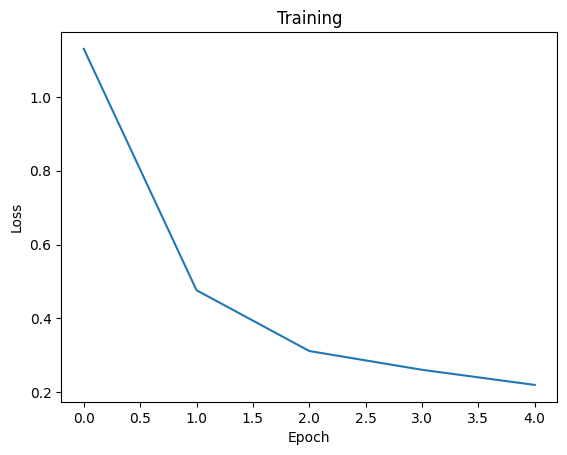

In [38]:
plt.plot(train_epoch_losses)
plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


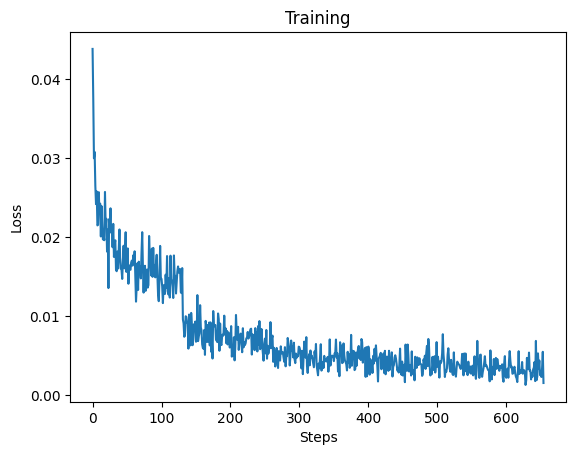

In [39]:
plt.plot(train_step_losses)
plt.title("Training")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()


Now let's check the performance on validation data after finetuning.

In [40]:
val_loss = 0
image_embeddings = []
text_embeddings = []
for image_batch, input_ids_batch, attention_mask_batch in tqdm(val_ds):
    image_embedding = img_model(image_batch, training=False)
    text_embedding = text_model([input_ids_batch, attention_mask_batch], training=False)

    image_embedding = tf.math.l2_normalize(image_embedding, axis=1)
    text_embedding = tf.math.l2_normalize(text_embedding, axis=1)

    image_embeddings.append(image_embedding.numpy())
    text_embeddings.append(text_embedding.numpy())

    # Compute the loss value for this minibatch.
    loss_value = loss_fn(text_embedding, image_embedding)
    val_loss += float(loss_value)
    
print(f"Mean Validation Loss: {val_loss / len(val_ds)}")
image_embeddings = np.concatenate(image_embeddings)
text_embeddings = np.concatenate(text_embeddings)


100%|██████████| 33/33 [00:05<00:00,  5.64it/s]

Mean Validation Loss: 0.8592189134973468


In [41]:
finetuned_sim = np.matmul(text_embeddings, image_embeddings.T)

for k in range(1, 6):
    print("R@{} : {}".format(k, recall_at_k(finetuned_sim, k)))


R@1 : 0.23065902578796563
R@2 : 0.3271251193887297
R@3 : 0.39255014326647564
R@4 : 0.4383954154727794
R@5 : 0.4775549188156638


## Search Using TF Similarity

We can see that thre is a significant imrovement in recall metric after only 5 epochs of training.
Now, we can use these modes for painting retrival based on text query.

In [48]:
imgs = [get_img_emb(fp) for fp in imgs_list] 

In [67]:
image_index = tfsim.models.SimilarityModel(img_model.inputs, img_model.outputs)
image_index.compile(distance="cosine")
try:
    image_index.reset_index()
except AttributeError:
    image_index.create_index()
image_index.index(imgs, data=[{"imgs": i, "desc": d} for i,d in zip(imgs, text_list)])

[Indexing {tf.shape(x)} points]
|-Computing embeddings
328/328 [==============================] - 8s 19ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [110]:
SEARCH_QUERY = "Large waves crashing in the Japanese ukioe style"

query_tokens = tokenizer(
    [SEARCH_QUERY],
    padding="max_length",
    return_tensors="tf",
    truncation=True,
)
query_emb = text_model.predict([query_tokens["input_ids"], query_tokens["attention_mask"]])


lookups = image_index._index.batch_lookup(predictions=query_emb, k=5, verbose=0)[0]


1/1 [==============================] - 0s 76ms/step


Katsushika Hokusai’s much celebrated series, Thirty-Six Views of Mount Fuji (Fugaku sanjûrokkei), was begun in 1830,
when the artist was 70 years old. This tour-de-force series established the popularity of landscape prints, which
continues to this day. Perhaps most striking about the series is Hokusai’s copious use of the newly affordable Berlin
blue pigment, featured in many of the compositions in the color for the sky and water. Mount Fuji is the protagonist in
each scene, viewed from afar or up close, during various weather conditions and seasons, and from all directions.


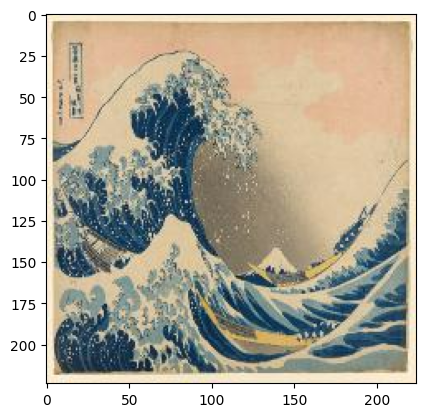




Katsushika Hokusai’s much celebrated series, Thirty-Six Views of Mount Fuji (Fugaku sanjûrokkei), was begun in 1830,
when the artist was 70 years old. This tour-de-force series established the popularity of landscape prints, which
continues to this day. Perhaps most striking about the series is Hokusai’s copious use of the newly affordable Berlin
blue pigment, featured in many of the compositions in the color for the sky and water. Mount Fuji is the protagonist in
each scene, viewed from afar or up close, during various weather conditions and seasons, and from all directions.


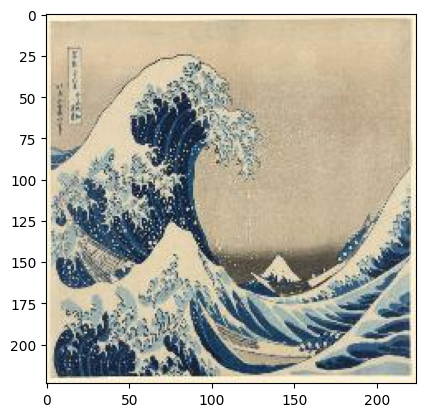




Katsushika Hokusai’s much celebrated series, Thirty-Six Views of Mount Fuji (Fugaku sanjûrokkei), was begun in 1830,
when the artist was 70 years old. This tour-de-force series established the popularity of landscape prints, which
continues to this day. Perhaps most striking about the series is Hokusai’s copious use of the newly affordable Berlin
blue pigment, featured in many of the compositions in the color for the sky and water. Mount Fuji is the protagonist in
each scene, viewed from afar or up close, during various weather conditions and seasons, and from all directions.


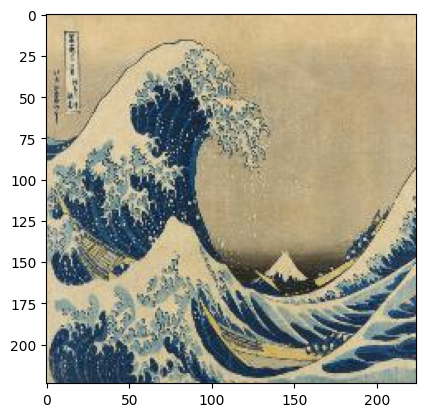




Louis-Auguste Lepére began his career as a commercial wood engraver, but in 1885 he decided to begin making his own
original woodcuts. Moved by Japanese prints exhibited at the 1888 Exposition Internationale de Blanc et Noir and the
1889 Exposition Universelle, Lepére experimented with the color woodcut process. ', <em>Breaking Waves</em>, ' pays
homage to the ocean imagery popular in the islands of Japan and integrates a diagonally recessed shoreline with a
horizon line just above the center elements that find a counterpart in Utagawa Hiroshige’s ', <em>Hamamatsu</em>, '.


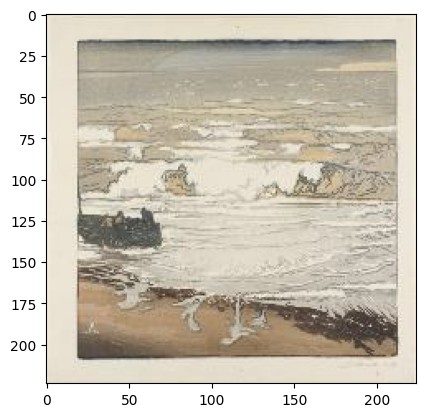




This print was made in the year of the rabbit, and the animal has a minor role on the print surface: as a part of the
decoration on the packaging of a child’s fishing game. The fishing game came in a simple package printed with a pattern
of waves. The title on the package reads ', <em>Haru no umi</em>, ', literally the “Ocean of Spring,” or, in this
context, “New Year’s Ocean.” The object of the game was to hook the large red sea bream, a traditional New Year
delicacy, with the small fishing pole provided. The game was probably played at New Year’s, when everyone took a break
from work and spent their time eating, visiting, and playing.


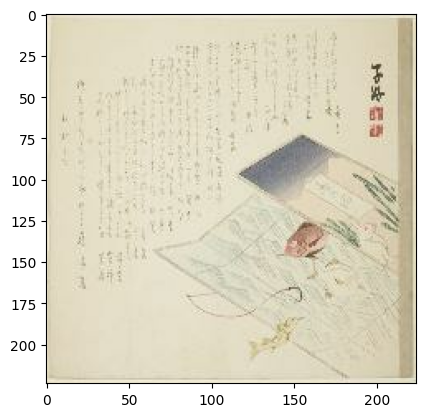

In [111]:
 for i in range(len(lookups)):
    matching_img = lookups[i].data["imgs"]
    matching_desc = lookups[i].data["desc"]

    print('\n'.join(textwrap.wrap(matching_desc, width=120)))
    # Channel order is C W H and we need to roll the axis to make it W H C
    plt.imshow(np.rollaxis(matching_img.numpy(), 0, 3));
    plt.show()

    print('\n\n')

## Model Saving
The models can be saved in the same way as any other keras model.

In [ ]:
img_model.save("image_model.h5")
text_model.save("text_model.h5")


However when loading these saved models, the CLIP vision and text models must be provided in custom objects.

In [ ]:
img_model = tf.keras.models.load_model("image_model.h5", custom_objects={"TFCLIPVisionModel": TFCLIPVisionModel})
text_model = tf.keras.models.load_model("text_model.h5", custom_objects={"TFCLIPTextModel": TFCLIPTextModel})
